Import modules

In [1]:
from lib.datasets import get_stock_price,train_test_split,get_OU,rolling_window_1D
from lib.aug import apply_augmentations,parse_augmentations,sig_normal
import torch
from torch import nn
import torch.nn.functional as F
from lib.utils import set_seed
import signatory
from models.vae import VAE, VAE_train
from models.betavae import BetaVAE, BetaVAE_train
from models.infovae import InfoVAE, InfoVAE_train
from models.wae import WAE,WAE_train
from lib.metrics import mmd_loss,SignatureKernel,RBFKernel
import numpy as np
import matplotlib.pyplot as plt

In [2]:
set_seed(0)

The considered truncated signature degree.

In [3]:
sig_degree = [3,4,5]

Get synthetic data

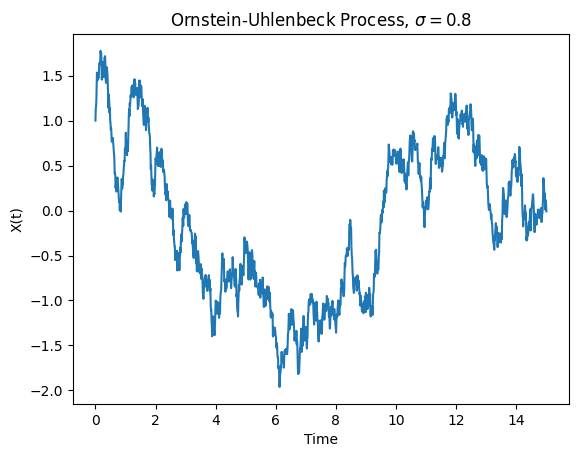

In [4]:
T = 15
dt = 0.01
N = int(T/dt)
sigma_1 = 0.8
ou_process_1 = get_OU(T=T,sigma=sigma_1).astype(np.float32)

# Plot the result
plt.plot(np.linspace(0, T, N), ou_process_1)
plt.title("Ornstein-Uhlenbeck Process, $\sigma=0.8$")
plt.xlabel("Time")
plt.ylabel("X(t)")
plt.show()


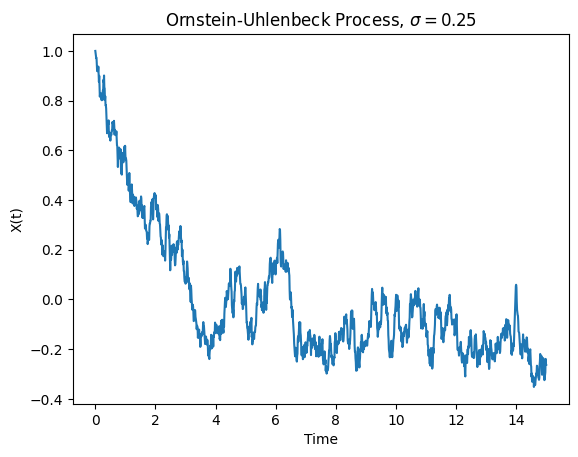

In [5]:
sigma_2 = 0.25
ou_process_2 = get_OU(T=T,sigma=sigma_2).astype(np.float32)

# Plot the result
plt.plot(np.linspace(0, T, N), ou_process_2)
plt.title("Ornstein-Uhlenbeck Process, $\sigma=0.25$")
plt.xlabel("Time")
plt.ylabel("X(t)")
plt.show()

In [6]:
sig_degree = [3,4,5]
sig_config = {
    "augmentations": [{"name": "LeadLag"}],
    "device" : "cuda",
    "depth" : sig_degree[2], # degree = 4
}

Get path augmentations.

In [7]:
if sig_config["augmentations"] is not None:
    sig_config["augmentations"] = parse_augmentations(sig_config.get('augmentations'))

Data preprocessing.
- Apply rolling window.
- Split training data and testing data.
- Apply path augmentations to original path.
- Calculate signature.
- Normalize signatures.
- Pass to CUDA.

In [8]:
tensor_data_1 = rolling_window_1D(torch.from_numpy(ou_process_1),window_size=30).view(-1,30,1)
tensor_data_2 = rolling_window_1D(torch.from_numpy(ou_process_2),window_size=30).view(-1,30,1)


x_real_train_1, x_real_test_1 = train_test_split(tensor_data_1, train_test_ratio=0.8, device=sig_config["device"])
print("x_real_train_1 shape {}, x_real_test shape {}".format(x_real_train_1.shape,x_real_test_1.shape))
x_real_train_2, x_real_test_2 = train_test_split(tensor_data_2, train_test_ratio=0.8, device=sig_config["device"])
print("x_real_train_1 shape {}, x_real_test shape {}".format(x_real_train_2.shape,x_real_test_2.shape))

if sig_config["augmentations"] is not None:
    # Print the tensor shape after each augmentation
    x_aug_train_1, x_aug_test_1 = apply_augmentations(x_real_train_1,sig_config["augmentations"]), apply_augmentations(x_real_test_1,sig_config["augmentations"])
    x_aug_train_2, x_aug_test_2 = apply_augmentations(x_real_train_2,sig_config["augmentations"]), apply_augmentations(x_real_test_2,sig_config["augmentations"])
print("After augmentation shape:",x_aug_train_1.shape)

# To signature
x_sig_train_1, x_sig_test_1 = signatory.signature(x_aug_train_1,sig_config["depth"]),signatory.signature(x_aug_test_1,sig_config["depth"])
x_sig_train_2, x_sig_test_2 = signatory.signature(x_aug_train_2,sig_config["depth"]),signatory.signature(x_aug_test_2,sig_config["depth"])
print("x_sig_train shape {}, x_sig_test shape {}".format(x_sig_train_1.shape,x_sig_test_1.shape))
input_dim = x_sig_train_1.shape[1]
print("input_dim: {}".format(input_dim))

# Normalize
x_sig_train_1, x_sig_test_1 = sig_normal(x_sig_train_1,True).to(sig_config["device"]), sig_normal(x_sig_test_1,True).to(sig_config["device"])
x_sig_train_2, x_sig_test_2 = sig_normal(x_sig_train_2,True).to(sig_config["device"]), sig_normal(x_sig_test_2,True).to(sig_config["device"])

Tensor shape before rolling: torch.Size([1500])
Tensor shape after rolling: torch.Size([1471, 30])
Tensor shape before rolling: torch.Size([1500])
Tensor shape after rolling: torch.Size([1471, 30])
x_real_train_1 shape torch.Size([1176, 30, 1]), x_real_test shape torch.Size([295, 30, 1])
x_real_train_1 shape torch.Size([1176, 30, 1]), x_real_test shape torch.Size([295, 30, 1])
torch.Size([1176, 59, 2])
torch.Size([295, 59, 2])
torch.Size([1176, 59, 2])
torch.Size([295, 59, 2])
After augmentation shape: torch.Size([1176, 59, 2])
x_sig_train shape torch.Size([1176, 62]), x_sig_test shape torch.Size([295, 62])
input_dim: 62


In [9]:
# For degree = 3
hidden_dim_degree3 = [input_dim,7,3] # input_dim = 14

# For degree = 4
hidden_dim_degree4 = [input_dim,15,7] # input_dim = 30

# For degree = 5
hidden_dim_degree5 = [input_dim,32,16] # input_dim = 62

Set degree = 3. Train models for $\sigma=0.8$

In [10]:
# VAE
model_vae = VAE(x_aug_sig=x_sig_train_1,epoch=6000,batch_size=128,device="cuda",hidden_dims=hidden_dim_degree3)
vae_optimizer = torch.optim.Adam(model_vae.parameters(), lr=1e-4)
VAE_train(model_vae,optimizer=vae_optimizer)

Input tensor shape: torch.Size([1176, 62])
Hidden dims: [62, 7, 3]


Epoch 0 loss 1.65
Epoch 100 loss 1.62
Epoch 200 loss 1.39
Epoch 300 loss 3.13
Epoch 400 loss 1.65
min_loss: 1.24


In [11]:
# Beta-VAE
model_betavae = BetaVAE(x_sig_train_1,6000,128,beta=3.5,device='cuda',hidden_dims=hidden_dim_degree3)
beta_optimizer = torch.optim.Adam(model_betavae.parameters(), lr=1e-4)
BetaVAE_train(model=model_betavae,optimizer=beta_optimizer)

Input tensor shape: torch.Size([1176, 62])
Hidden dims: [62, 7, 3]
Beta: 3.5
Epoch 0 loss 123.79
Epoch 100 loss 112.85
Epoch 200 loss 91.99
Epoch 300 loss 250.75
Epoch 400 loss 93.56
Epoch 500 loss 146.85
Epoch 600 loss 167.13
min_loss: 78.14


In [12]:
# Info-VAE
model_infovae = InfoVAE(x_aug_sig=x_sig_train_1,epoch=6000,batch_size=128,hidden_dims=hidden_dim_degree3,device='cuda')
info_optimizer = torch.optim.Adam(model_infovae.parameters(), lr=1e-4) 
InfoVAE_train(model_infovae,info_optimizer)

Input tensor shape: torch.Size([1176, 62])
Hidden dims: [62, 7, 3]
Epoch 0 loss 2.20
Epoch 100 loss 1.80
Epoch 200 loss 1.82
Epoch 300 loss 1.65
Epoch 400 loss 3.99
min_loss: 1.42


In [13]:
# WAE-MMD
model_waemmd = WAE(x_aug_sig=x_sig_train_1,epoch=6000,batch_size=128,hidden_dims=hidden_dim_degree3,device='cuda')
cvae_optimizer = torch.optim.Adam(model_waemmd.parameters(), lr=1e-4) 
WAE_train(model_waemmd,cvae_optimizer)

Epoch 0 loss 1.62
Epoch 100 loss 2.15
Epoch 200 loss 2.16
Epoch 300 loss 2.34
Epoch 400 loss 2.22
Epoch 500 loss 2.16
Epoch 600 loss 2.91
min_loss: 1.33


Evaluate.

In [14]:
KLD = nn.KLDivLoss(reduction="batchmean")
sigkernel = SignatureKernel(static_kernel=RBFKernel(sigma=1.0))

In [15]:
models = [model_vae,model_betavae,model_infovae,model_waemmd]
for model in models:
    _, _, z = model_vae.encode(x_sig_test_1)
    reconstructed_sig = model_vae.decode(z)
    reconstructed_sig = sig_normal(reconstructed_sig,True)

    # Mean of L2 norm over the batch dimension
    L2 = F.mse_loss(x_sig_test_1,reconstructed_sig)
    # Mean of JS divergence over the batch dimension
    js = (KLD(x_sig_test_1,reconstructed_sig)+KLD(reconstructed_sig,x_sig_test_1))/2
    # signature MMD
    mmd = mmd_loss(x_sig_test_1,reconstructed_sig,sigkernel)

    print("L2 ({}): {:.3f}".format(model.type,L2.item()))
    print("JS ({}): {:.3f}".format(model.type,js.item()))
    print("mmd ({}): {:.3f}".format(model.type,mmd.item()))

L2 (VAE): 2.029
JS (VAE): 7.411
mmd (VAE): 0.025
L2 (Beta-VAE): 1.973
JS (Beta-VAE): 6.635
mmd (Beta-VAE): 0.025
L2 (Info-VAE): 1.919
JS (Info-VAE): 5.350
mmd (Info-VAE): 0.025
L2 (WAE): 2.016
JS (WAE): 7.845
mmd (WAE): 0.025


Plot training loss.

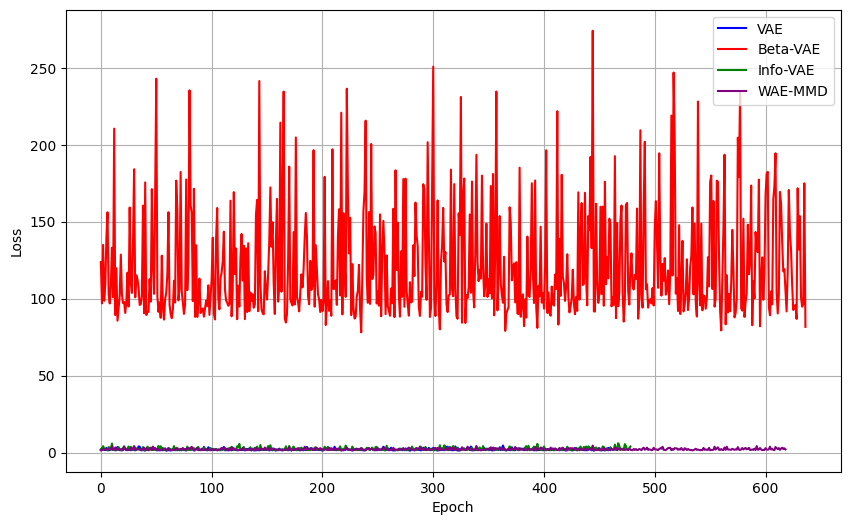

In [16]:
import matplotlib.pyplot as plt

# Create a figure
plt.figure(figsize=(10, 6))

# Plot each model's loss with a different label and color
plt.plot(range(len(model_vae.loss_record)), model_vae.loss_record, label='VAE', color='blue')
plt.plot(range(len(model_betavae.loss_record)), model_betavae.loss_record, label='Beta-VAE', color='red')
plt.plot(range(len(model_infovae.loss_record)), model_infovae.loss_record, label='Info-VAE', color='green')
plt.plot(range(len(model_waemmd.loss_record)), model_waemmd.loss_record, label='WAE-MMD', color='purple')

# Add labels and title
plt.xlabel('Epoch')
plt.ylabel('Loss')
# plt.title('Loss Curves for the stock dataset, $d=3$')
plt.legend()  # Add a legend to distinguish the models
plt.grid(True)  # Optional: adds a grid for better readability
plt.savefig('assets/loss_ou0.8_d4.png', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

Set degree = 3. Train models for $\sigma=0.25$

In [17]:
# VAE
model_vae = VAE(x_aug_sig=x_sig_train_2,epoch=6000,batch_size=128,device="cuda",hidden_dims=hidden_dim_degree3)
vae_optimizer = torch.optim.Adam(model_vae.parameters(), lr=1e-4)
VAE_train(model_vae,optimizer=vae_optimizer)

Input tensor shape: torch.Size([1176, 62])
Hidden dims: [62, 7, 3]
Epoch 0 loss 1.86
Epoch 100 loss 1.57
Epoch 200 loss 1.52
Epoch 300 loss 2.12
Epoch 400 loss 2.55
Epoch 500 loss 1.77
Epoch 600 loss 1.60
min_loss: 1.33


In [18]:
# Beta-VAE
model_betavae = BetaVAE(x_sig_train_2,6000,128,beta=3.5,device='cuda',hidden_dims=hidden_dim_degree3)
beta_optimizer = torch.optim.Adam(model_betavae.parameters(), lr=1e-4)
BetaVAE_train(model=model_betavae,optimizer=beta_optimizer)

Input tensor shape: torch.Size([1176, 62])
Hidden dims: [62, 7, 3]
Beta: 3.5
Epoch 0 loss 135.12
Epoch 100 loss 106.60
Epoch 200 loss 121.27
Epoch 300 loss 91.62
Epoch 400 loss 136.74
Epoch 500 loss 172.97
Epoch 600 loss 151.61
min_loss: 78.60


In [19]:
# Info-VAE
model_infovae = InfoVAE(x_aug_sig=x_sig_train_2,epoch=6000,batch_size=128,hidden_dims=hidden_dim_degree3,device='cuda')
info_optimizer = torch.optim.Adam(model_infovae.parameters(), lr=1e-4) 
InfoVAE_train(model_infovae,info_optimizer)

Input tensor shape: torch.Size([1176, 62])
Hidden dims: [62, 7, 3]
Epoch 0 loss 2.36
Epoch 100 loss 2.02
Epoch 200 loss 1.71
Epoch 300 loss 2.41
Epoch 400 loss 1.82
Epoch 500 loss 2.80
min_loss: 1.52


In [20]:
# WAE-MMD
model_waemmd = WAE(x_aug_sig=x_sig_train_2,epoch=6000,batch_size=128,hidden_dims=hidden_dim_degree3,device='cuda')
cvae_optimizer = torch.optim.Adam(model_waemmd.parameters(), lr=1e-4) 
WAE_train(model_waemmd,cvae_optimizer)

Epoch 0 loss 2.06
Epoch 100 loss 1.87
Epoch 200 loss 2.07
Epoch 300 loss 1.63
Epoch 400 loss 2.94
Epoch 500 loss 2.97
Epoch 600 loss 1.62
Epoch 700 loss 1.91
Epoch 800 loss 1.68
min_loss: 1.37


In [21]:
models = [model_vae,model_betavae,model_infovae,model_waemmd]
for model in models:
    _, _, z = model_vae.encode(x_sig_test_2)
    reconstructed_sig = model_vae.decode(z)
    reconstructed_sig = sig_normal(reconstructed_sig,True)

    # Mean of L2 norm over the batch dimension
    L2 = F.mse_loss(x_sig_test_2,reconstructed_sig)
    # Mean of JS divergence over the batch dimension
    js = (KLD(x_sig_test_2,reconstructed_sig)+KLD(reconstructed_sig,x_sig_test_2))/2
    # signature MMD
    mmd = mmd_loss(x_sig_test_2,reconstructed_sig,sigkernel)

    print("L2 ({}): {:.3f}".format(model.type,L2.item()))
    print("JS ({}): {:.3f}".format(model.type,js.item()))
    print("mmd ({}): {:.3f}".format(model.type,mmd.item()))

L2 (VAE): 2.001
JS (VAE): 3.231
mmd (VAE): 0.030
L2 (Beta-VAE): 2.029
JS (Beta-VAE): 3.586
mmd (Beta-VAE): 0.030
L2 (Info-VAE): 2.018
JS (Info-VAE): 3.727
mmd (Info-VAE): 0.029
L2 (WAE): 2.070
JS (WAE): 4.537
mmd (WAE): 0.032


Plot training loss.

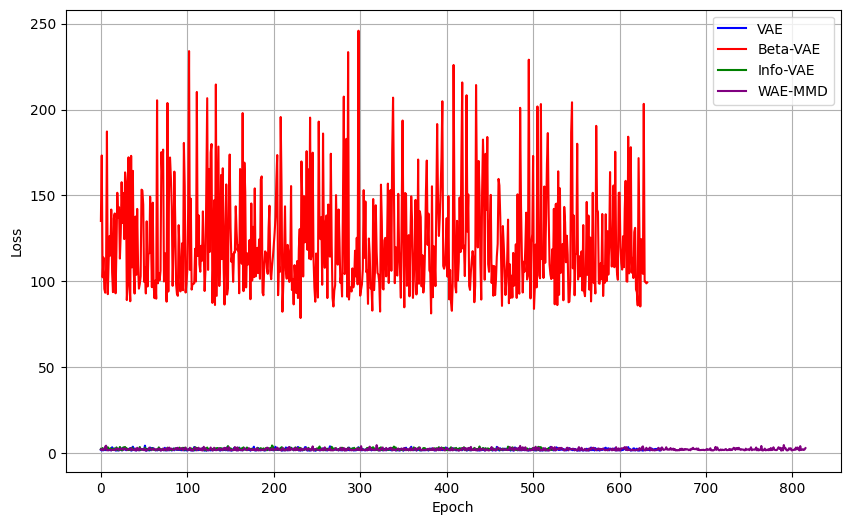

In [22]:
import matplotlib.pyplot as plt

# Create a figure
plt.figure(figsize=(10, 6))

# Plot each model's loss with a different label and color
plt.plot(range(len(model_vae.loss_record)), model_vae.loss_record, label='VAE', color='blue')
plt.plot(range(len(model_betavae.loss_record)), model_betavae.loss_record, label='Beta-VAE', color='red')
plt.plot(range(len(model_infovae.loss_record)), model_infovae.loss_record, label='Info-VAE', color='green')
plt.plot(range(len(model_waemmd.loss_record)), model_waemmd.loss_record, label='WAE-MMD', color='purple')

# Add labels and title
plt.xlabel('Epoch')
plt.ylabel('Loss')
# plt.title('Loss Curves for the stock dataset, $d=3$')
plt.legend()  # Add a legend to distinguish the models
plt.grid(True)  # Optional: adds a grid for better readability
plt.savefig('assets/loss_ou0.25_d5.png', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()